# Machine Learning - Practical 6

In this practical we will work with clustering algorithms. Even though some groups might already have enought points to be admitted to the exam, we strongly recommend to work through this exercise sheet.
The outline is as follows:

 1. Imports
 2. Load and visualize the data
 3. k-means with sklearn
 4. Gaussian Mixture Models implementation
 5. Comparison of methods on the data

In [1]:
import pickle
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

sns.set(context='talk',style='white',palette='colorblind')

## Task 0: Load data

To explore different clustering algorithms, we generated a toy dataset that consists of 5000 data points from a two dimensional mixture of Gaussian model with seven clusters.
Plot the data points with different colors for each cluster and indicated the cluster means.

In [2]:
# load data
with open('/kaggle/input/data-gmms/data_gmms.pkl', 'rb') as f:
    dataset = pickle.load(f)

print(dataset.keys())
print(dataset["data"].shape)

dict_keys(['data', 'labels', 'means'])
(5000, 2)


In [3]:
def plot_clustering(data, cluster_ids, means, title):
    '''
    Plots the (2D) data as scatter plot, with different colors and an extra symbol for the mean per cluster.
    inputs:
        data        -- (n_samples, n_features)-shaped array of data
        cluster_ids -- (n_samples,)-shaped array of integers that hold the cluster assignment for each data point
        means       -- (n_clusters, n_features)-shaped array of mean vectors
        title       -- string that is added as title

    '''

    # ---------------- INSERT CODE ----------------------
    
    plt.title(title)
    plt.scatter(data[:,0], data[:,1], c=cluster_ids, marker = ".")
    plt.scatter(means[:,0], means[:,1], c = "red", marker = "x")
    plt.show()
    
    # ---------------- END CODE -------------------------

In [4]:
toy_data = dataset['data']
toy_cluster_ids_true = dataset['labels']
toy_means = dataset['means']

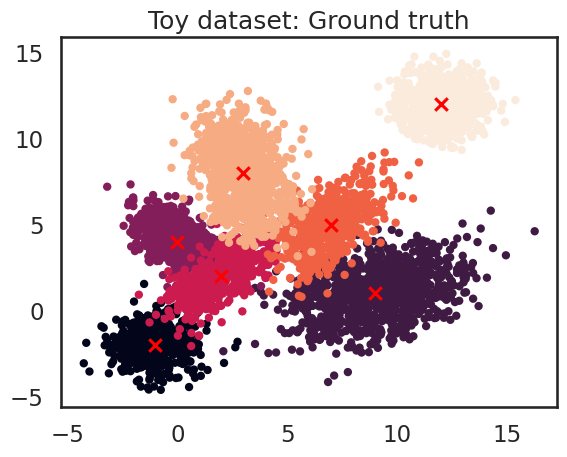

In [5]:
plot_clustering(toy_data, toy_cluster_ids_true, toy_means, 'Toy dataset: Ground truth')

## Task 1: Cluster the data using k-Means

First, we will implement k-Means as an example of a simple clustering algorithm and see how it performs on the dataset. 

Use the function KMeans provided by sklearn to perform K-Means with different numbers of clusters, for instance 3, 5, 7, 10 and 20.

In [6]:
def run_KMeans(data, n_clusters):
    '''Function that performs K-means clustering for a given number of clusters.
        input:
            data: (n_samples, n_features)-shaped array of data
            number of clusters: int, number of clusters
        output:
            kmeans_result: (n_samples,)-shaped array of integers that hold the cluster assignment for each data point
    '''

    # ---------------- INSERT CODE ----------------------
    
    kmeans = KMeans(n_clusters=n_clusters).fit(data)
    kmeans_result = kmeans.labels_
    kmeans_mean = kmeans.cluster_centers_
    
    
    # ---------------- END CODE -------------------------
    return kmeans_result, kmeans_mean

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


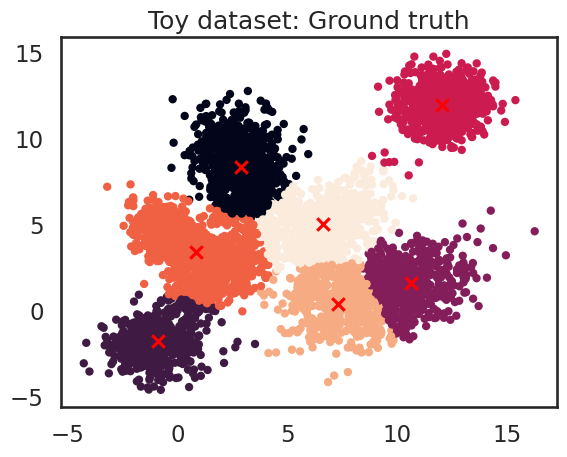

In [7]:
# run kmeans with different numbers of clusters

# ---------------- INSERT CODE ----------------------

cluster_ids,cluster_mean = run_KMeans(toy_data, 7)
plot_clustering(toy_data, cluster_ids, cluster_mean, 'Toy dataset: Ground truth')

# ---------------- END CODE -------------------------

Plot your results as cluster labels using the "plot_clustering" function and compare it to the original cluster labels. Describe your results.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


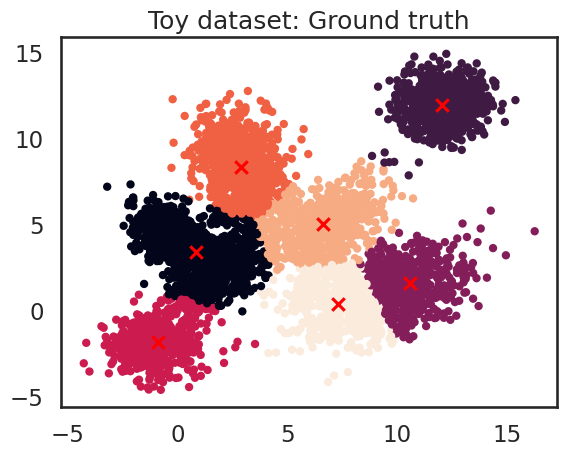

In [8]:
# plot results
# ---------------- INSERT CODE ----------------------
cluster_ids,cluster_mean = run_KMeans(toy_data, 7)
plot_clustering(toy_data, cluster_ids, cluster_mean, 'Toy dataset: Ground truth')

# ---------------- END CODE -------------------------

YOUR ANSWER HERE

##  Task 2: Clustering using Gaussian Mixture Models

Next, we will implement clustering with Gaussian Mixture models as discussed in the Bishop in Chapter 9.2.2 pg. 435-439.

Implement the EM algorithm to fit a Gaussian mixture model on the data. Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. 

For this task, it is important to think about a good way to initialize the means, covariances and mixing coefficients. Also, during optimization, covariance matrices can become singular. To prevent this, you can add a small constant (like $10^{-5}$) to the diagonal.

In order to speed up the computation, define a convergence criterion that stops the algorithm after convergence.

In [9]:
def mv_gaussian(mean,cov,x):
    
    d = mean.shape[1]/2
    return (2*math.pi)**(-d) * np.linalg.det(cov)**(-0.5) * math.exp(-0.5*(x-mean)@np.linalg.inv(c)@(x-m).T)



In [17]:
from scipy.stats import multivariate_normal

def gmm(data, n_clusters, verbose=True, max_iter=1000, convergence_threshold=1e-4):
    '''Function that fits a mixture of gaussians to data.
    
    inputs:
        data          -- (n_samples, n_features)-shaped array of data points
        n_clusters    -- int, number of clusters / mixture components
        verbose       -- bool, if True, print current likelihood after each EM iteration
        max_iter      -- maximum number of EM iterations
        convergence_threshold  -- stop algorithm if change in log-likelihood is below the threshold
        
    outputs:
        cluster_ids -- (n_samples,)-shaped array of integers that hold the cluster assignment for each data point
        means       -- (n_clusters, n_features)-shaped array of fit mean vectors
        covs        -- (n_features, n_features, n_clusters)-shaped array of fit covariance matrices
        priors      -- (n_clusters)-shaped arrays of fit priors / mixing coefficients
    '''

    # ---------------- INSERT CODE ----------------------

    ### INITIALIZATION ###

    # Initialize the means, covariances, and priors randomly
    means = np.random.randn(n_clusters, data.shape[1])
    priors = np.random.dirichlet(np.ones(n_clusters))
    
    covs = np.zeros((n_clusters, data.shape[1], data.shape[1]))
    for k in range(n_clusters):
        random_matrix = np.random.randn(data.shape[1], data.shape[1])
        covs[k] = np.dot(random_matrix, random_matrix.T)

    # Initialize the cluster assignments
    cluster_ids = np.zeros(data.shape[0])

    # Iterate between the E-step and M-step until convergence or maximum iterations
    for _ in range(max_iter):

        ### E-STEP ###

        # Compute the responsibilities for each data point and cluster
        responsibilities = np.zeros((data.shape[0], n_clusters))
        for k in range(n_clusters):
            responsibilities[:, k] = priors[k] * multivariate_normal.pdf(data, mean=means[k], cov=covs[k])

        # Normalize the responsibilities
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

        ### M-STEP ###

        # Update the means, covariances, and priors based on the responsibilities
        for k in range(n_clusters):
            means[k] = np.dot(responsibilities[:, k], data) / np.sum(responsibilities[:, k])
            centered_data = data - means[k]
            covs[k] = np.dot(responsibilities[:, k] * centered_data.T, centered_data) / np.sum(responsibilities[:, k])
            priors[k] = np.mean(responsibilities[:, k])

        ### CHECK FOR CONVERGENCE / PRINT LOG_LIKELIHOOD if VERBOSE ###

        # Compute the log-likelihood
        log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1)))

        if verbose:
            print("Log-Likelihood:", log_likelihood)

        # Check for convergence
        if _ > 0 and np.abs(log_likelihood - prev_log_likelihood) < convergence_threshold:
            break

        prev_log_likelihood = log_likelihood

    ### ASSIGN CLUSTER LABELS ###

    cluster_ids = np.argmax(responsibilities, axis=1)

    # ---------------- END CODE -------------------------

    return cluster_ids, means, covs, priors

Explore the results of GMM using different numbers of clusters and initialization strategies.

In [24]:
# fit GMM

n_clusters = 7
cluster_ids, means, covs, priors = gmm(toy_data, n_clusters,convergence_threshold = 1e-100)


Log-Likelihood: -3.597122599785507e-14
Log-Likelihood: -5.195843755245734e-14
Log-Likelihood: -4.940492459581947e-14
Log-Likelihood: -6.084022174945858e-14
Log-Likelihood: -4.973799150320702e-14
Log-Likelihood: -5.617728504603293e-14
Log-Likelihood: -6.006306563222097e-14
Log-Likelihood: -5.24025267623074e-14
Log-Likelihood: -4.130029651605584e-14
Log-Likelihood: -5.4067861299245136e-14
Log-Likelihood: -5.317968287954501e-14
Log-Likelihood: -5.173639294753231e-14
Log-Likelihood: -4.6074255521944015e-14
Log-Likelihood: -4.096722960866829e-14
Log-Likelihood: -5.4067861299245136e-14
Log-Likelihood: -5.0404125317982126e-14
Log-Likelihood: -5.584421813864539e-14
Log-Likelihood: -4.962696920074451e-14
Log-Likelihood: -5.517808432387029e-14
Log-Likelihood: -4.829470157119432e-14
Log-Likelihood: -5.0293103015519604e-14
Log-Likelihood: -6.217248937900878e-14
Log-Likelihood: -4.5408121707168915e-14
Log-Likelihood: -5.895284260759582e-14
Log-Likelihood: -5.3734794391857595e-14
Log-Likelihood: -4.

Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? How does it compare to the k-Means solution? Plot ground truth, k-Means and GMM cluster assignment side-by-side to compare them.

If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.

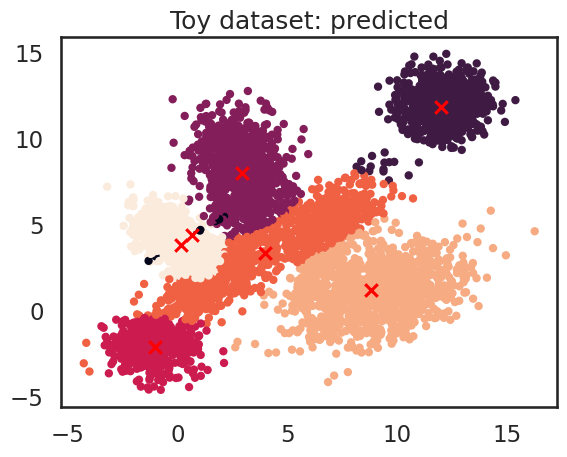

In [25]:
# plotting
plot_clustering(toy_data, cluster_ids, means, 'Toy dataset: predicted')


YOUR ANSWER HERE